# Configure Hydra to load the config file for models and datasets

In [1]:
from hydra import initialize, compose


In [2]:
with initialize(version_base=None, config_path="config"):
    cfg = compose(overrides=["+models=gcn", '+datasets=mutag'])
    print(cfg)

{'models': {'gnn_saving_path': 'checkpoints', 'gnn_name': 'gcn', 'param': {'ba_2motifs': {'learning_rate': 0.005, 'weight_decay': 0.0, 'milestones': 'None', 'gamma': 'None', 'batch_size': 32, 'num_epochs': 1000, 'num_early_stop': 100, 'gnn_latent_dim': [20, 20, 20], 'gnn_dropout': 0.0, 'add_self_loop': True, 'gcn_adj_normalization': False, 'gnn_emb_normalization': False, 'graph_classification': True, 'node_classification': False, 'gnn_nonlinear': 'relu', 'readout': 'mean', 'fc_latent_dim': [], 'fc_dropout': 0.0, 'fc_nonlinear': 'relu'}, 'bace': {'learning_rate': 0.01, 'weight_decay': 0.0, 'milestones': 'None', 'gamma': 'None', 'batch_size': 64, 'num_epochs': 400, 'num_early_stop': 0, 'gnn_latent_dim': [128, 128, 128], 'gnn_dropout': 0.0, 'add_self_loop': True, 'gcn_adj_normalization': True, 'gnn_emb_normalization': False, 'graph_classification': True, 'node_classification': False, 'gnn_nonlinear': 'relu', 'readout': 'max', 'fc_latent_dim': [], 'fc_dropout': 0.0, 'fc_nonlinear': 'relu'}

In [3]:
cfg.models.param = cfg.models.param[cfg.datasets.dataset_name]

In [4]:
import os
import time
from omegaconf import OmegaConf

import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets.datasets import get_dataset, get_data_loader
from explainers.shapley_rule import KernelShapRule
from models.gnnNets import get_gnnNets
from utils import parse_rules
import numpy as np
from tqdm import tqdm

In [8]:
def simple_rule_score(model, dataset, dataloader, activation_rules, df, k=100):
    estimator = KernelShapRule('ba2', model, dataset, dataloader, activation_rules, targeted_class=0,
                               strategy='deactivate')
    estimator.add_sampled_coalition(k)
    estimator.fit()
    values = estimator.get_shapley_values()
    for i, values in enumerate(values):
        df.loc[i, 'contribution_class_0'] = values

    estimator = KernelShapRule('ba2', model, dataset, dataloader, activation_rules, targeted_class=1,
                               strategy='deactivate')
    estimator.add_sampled_coalition(k)
    estimator.fit()
    values = estimator.get_shapley_values()
    # Rounded to 3 decimals the time taken
    for i, values in enumerate(values):
        df.loc[i, 'contribution_class_1'] = values
    return df


def progressive_rule_score(model, dataset, dataloader, activation_rules, targeted_class=0):
    """
    Compute the progressive rule score for each rule in the activation_rules list
    :param model: GNN model
    :param dataset: dataset
    :param dataloader: dataloader
    :param activation_rules: list of rules
    :param targeted_class: target class
    :return: list of progressive rule scores
    """
    progressive_rule_scores = []
    estimator = KernelShapRule('ba2', model, dataset, dataloader, activation_rules, targeted_class=targeted_class)
    for _ in tqdm(range(2)):
        estimator.add_sampled_coalition(100)
        estimator.fit()
        progressive_rule_scores.append(estimator.get_shapley_values())
    return progressive_rule_scores



In [9]:
def run(config):
    dataset = get_dataset(
        dataset_root=config.datasets.dataset_root,
        dataset_name=config.datasets.dataset_name,
    )
    dataset.data.x = dataset.data.x.float()
    dataset.data.y = dataset.data.y.squeeze().long()

    print(dataset)
    print(max([d.num_nodes for d in dataset]))
    # Get only train set
    model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models)
    # Load model state dict
    pretrained_model = torch.load(
        "../" + config.models.gnn_saving_path + "/" + f'{config.datasets.dataset_name}/{config.models.gnn_name}_3l_best.pth')
    model.load_state_dict(pretrained_model['net'])
    dataloader = get_data_loader(dataset, config.models.param.batch_size, config.datasets.random_split_flag,
                                 config.datasets.data_split_ratio, config.datasets.seed)

    activation_rules = parse_rules(f'../ExplanationEvaluation/{config.datasets.dataset_name}_encode_motifs.csv', emb_size=128)
    print(f'Activation rules length: {len(activation_rules)}')
    # Only keep acitvation rule of class 0
    activation_rules = [rule for rule in activation_rules if rule[2] == 0]
    df_result = pd.DataFrame(columns=['rule_layer', 'rule_vector', 'rule_target', 'contribution_class_0',
                                      'contribution_class_1'])
    for i, (layer, vector, target, _, _, _) in enumerate(activation_rules):
        df_result.loc[i] = [layer, vector, target, 0, 0,]
    for layer, vector, target, _, _, _ in activation_rules:
        print(f'Layer: {layer}, Vector: {vector}, Target: {target}')
    print(f'Number of rules: {len(activation_rules)}')
    df = simple_rule_score(model, dataset, dataloader, activation_rules, df_result, k=100)

    # Add rule from activation_rules to the df
    df['rule_inside_score'] = [val[3] for val in activation_rules]
    df['rule_inside_score_c0'] = [val[4] for val in activation_rules]
    df['rule_inside_score_c1'] = [val[5] for val in activation_rules]

    df.to_csv(f'../ExplanationEvaluation/{config.datasets.dataset_name}_kernel_shapley_rule.csv', index=False)
    print(df)
    print(len(df))
    # Plot the values for each rule with the rule_target as color according to the rule_inside_score
    plt.scatter(df['contribution_class_0'], df['contribution_class_1'], c=df['rule_inside_score'], cmap='viridis')
    plt.colorbar()
    plt.xlabel('Contribution to class 0')
    plt.ylabel('Contribution to class 1')
    plt.title(f'Estimated Shapley values for each rule, k=100')
    plt.savefig('../ExplanationEvaluation/ex_ba2_contrib_score_c_k100.png')
    plt.show()

    # Plot the values for each rule with the rule_target as color according to the rule_inside_score_c0
    plt.scatter(df['contribution_class_0'], df['contribution_class_1'], c=df['rule_inside_score_c0'], cmap='viridis')
    plt.colorbar()
    plt.xlabel('Contribution to class 0')
    plt.ylabel('Contribution to class 1')
    plt.title(f'Estimated Shapley values for each rule, k=100')
    plt.savefig('../ExplanationEvaluation/ex_ba2_contrib_score_c0_k100.png')
    plt.show()

    # Plot the values for each rule with the rule_target as color according to the rule_inside_score_c1
    plt.scatter(df['contribution_class_0'], df['contribution_class_1'], c=df['rule_inside_score_c1'], cmap='viridis')
    plt.colorbar()
    plt.xlabel('Contribution to class 0')
    plt.ylabel('Contribution to class 1')
    plt.title(f'Estimated Shapley values for each rule, k=100')
    plt.savefig('../ExplanationEvaluation/ex_ba2_contrib_score_c1_k100.png')
    plt.show()

    return df



/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/elouan/epita/lre/new_code_base/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


MUTAG(188)
28
Activation rules length: 46
Layer: 0, Vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.], Target: 0
Layer: 0, Vector: [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 1.], Target: 0
Layer: 0, Vector: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1.

100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


0     0.553455
1     0.489691
2     0.786381
3     0.844037
4     0.828157
        ...   
95    0.504991
96    0.586707
97    0.586688
98    0.793283
99    0.603929
Name: score, Length: 100, dtype: float64
Adding 100 sampled coalitions


100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


0     0.818912
1     0.710585
2     0.837185
3     0.856736
4     0.864575
        ...   
95    0.873667
96    0.864503
97    0.597676
98    0.323760
99    0.770775
Name: score, Length: 100, dtype: float64
   rule_layer                                        rule_vector rule_target  \
0           0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0   
1           0  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...           0   
2           0  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...           0   
3           0  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...           0   
4           0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0   
5           0  [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0   
6           0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0   
7           0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0   
8           0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          

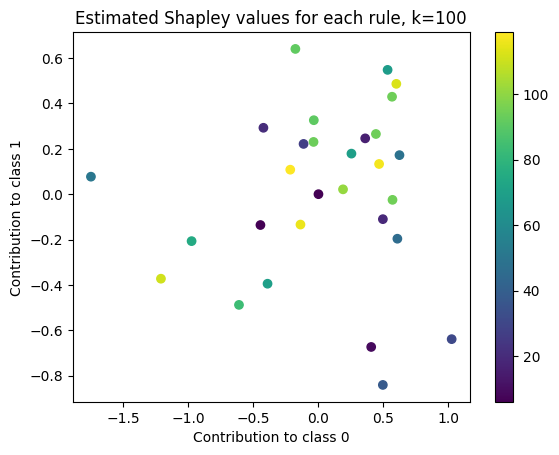

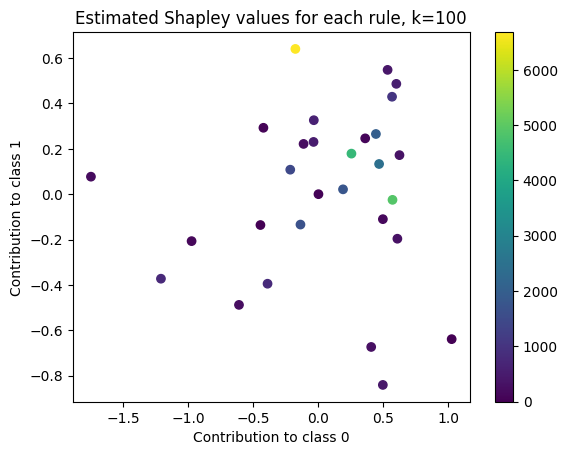

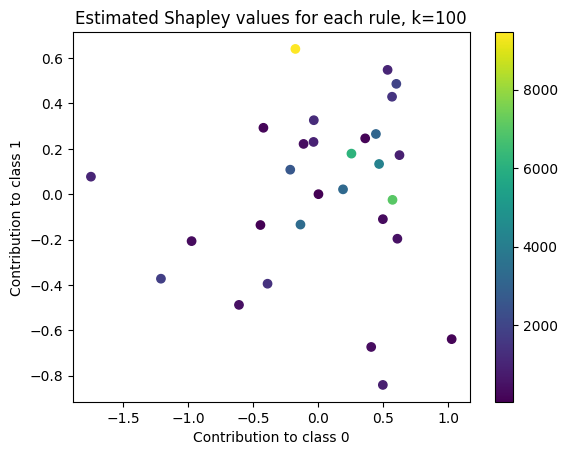

In [10]:

df = run(cfg)

In [11]:
df = pd.read_csv(f'../ExplanationEvaluation/{cfg.datasets.datasetname}_kernel_shapley_rule.csv')

ConfigAttributeError: Key 'datasetname' is not in struct
    full_key: datasets.datasetname
    object_type=dict

In [12]:
df

,rule_layer,rule_vector,rule_target,contribution_class_0,contribution_class_1,rule_inside_score,rule_inside_score_c0,rule_inside_score_c1
0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,-0.138381,-0.134065,115.628667,1690.291366,3332.218435
1,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",0,0.598805,0.48668,112.778996,549.555145,1948.014698
2,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,0.188875,0.021379,101.000935,1782.713705,3216.926986
3,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,0.441881,0.265505,94.232124,1991.146702,3103.085769
4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,-0.975628,-0.207091,74.445520,119.868137,328.315595
5,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.253611,0.178898,69.293216,4485.348015,6134.526552
6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,-0.391565,-0.395018,69.171904,796.130697,1404.843452
7,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.531671,0.548315,68.066263,409.107409,1008.090522
8,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.606874,-0.196507,45.681981,295.981600,451.300335
9,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.495101,-0.841426,37.535458,420.015286,817.891138


In [13]:
# Remove rules with contribution to class 0 and class 1 equal to 0
df = df[(df['contribution_class_0'] != 0) | (df['contribution_class_1'] != 0)]

In [14]:
# Conver to float
df['contribution_class_1'] = df['contribution_class_1'].astype(float)
df['contribution_class_0'] = df['contribution_class_0'].astype(float)

/tmp/ipykernel_106567/60444906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contribution_class_1'] = df['contribution_class_1'].astype(float)
/tmp/ipykernel_106567/60444906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['contribution_class_0'] = df['contribution_class_0'].astype(float)


In [15]:
import scipy as sp

# Z score 
zscore_c = sp.stats.zscore(df['contribution_class_1'])

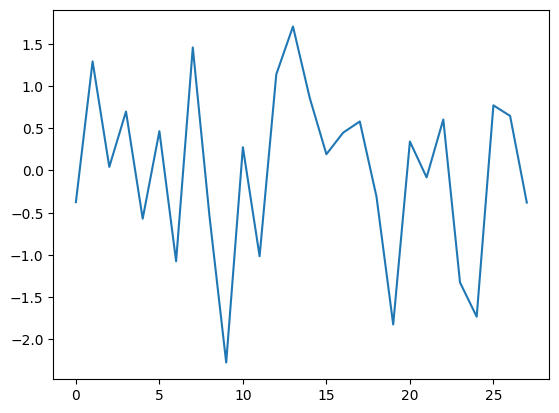

In [16]:
plt.plot(zscore_c)

In [ ]:
zscore_is = sp.stats.zscore(df['rule_inside_score_c0'])

In [ ]:
# Compute pearson correlation
res = sp.stats.pearsonr(zscore_c, zscore_is)

In [ ]:
res

PearsonRResult(statistic=-0.4550811570777946, pvalue=0.03818296160028799)

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp

TARGET_CLASS = 1

In [ ]:
df = pd.read_csv(f'../ExplanationEvaluation/ex_ba_2motifs_kernel_shapley_rule{TARGET_CLASS}.csv')

In [ ]:
df

,rule_layer,rule_vector,rule_target,contribution_class_0,contribution_class_1,rule_inside_score,rule_inside_score_c0,rule_inside_score_c1
0,0,[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.],1,-0.499977,0.022564,23.830343,915.582765,848.857803
1,1,[0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.],1,-0.053824,0.052812,138.703183,2319.310790,1847.719968
2,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],1,0.141849,0.009834,120.192011,681.271996,488.964778
3,1,[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.],1,0.237914,0.182825,118.449916,1491.927161,1089.197445
4,1,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.],1,0.062719,0.035089,111.237749,1192.277693,947.554646
5,1,[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.],1,-0.011361,-0.151906,74.658801,1734.589847,1435.954643
6,1,[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],1,0.102915,-0.070956,64.119393,397.902392,256.839728
7,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.],1,0.171813,0.138860,50.993103,1202.855827,1090.671001
8,1,[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.],1,0.122575,-0.032080,43.247968,319.004582,197.910272
9,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],1,0.212493,0.102712,29.398517,602.426400,555.388773


In [ ]:
df['contribution_class_1'] = df['contribution_class_1'].astype(float)
df['contribution_class_0'] = df['contribution_class_0'].astype(float)

In [ ]:
# Build a correlation matrix
corr_matrix = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        zscore_c = sp.stats.zscore(df[f'contribution_class_{i}'])
        zscore_is = sp.stats.zscore(df[f'rule_inside_score_c{j}'])
        corr_matrix[i,j] = sp.stats.pearsonr(zscore_c, zscore_is)[0]

<Axes: >

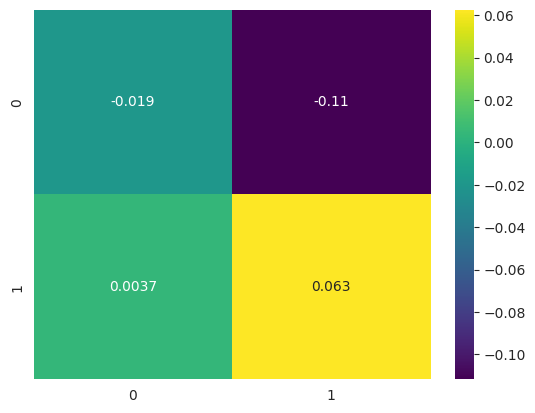

In [ ]:
import seaborn as sns

sns.heatmap(corr_matrix, annot=True, cmap='viridis')

In [ ]:
df.sort_values(by=['contribution_class_0'], ascending=False)


,rule_layer,rule_vector,rule_target,contribution_class_0,contribution_class_1,rule_inside_score,rule_inside_score_c0,rule_inside_score_c1
3,1,[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.],1,0.237914,0.182825,118.449916,1491.927161,1089.197445
9,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.],1,0.212493,0.102712,29.398517,602.426400,555.388773
7,1,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.],1,0.171813,0.138860,50.993103,1202.855827,1090.671001
2,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],1,0.141849,0.009834,120.192011,681.271996,488.964778
11,2,[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.],1,0.132084,0.022785,201.153456,1841.109857,1277.880181
8,1,[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.],1,0.122575,-0.032080,43.247968,319.004582,197.910272
6,1,[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],1,0.102915,-0.070956,64.119393,397.902392,256.839728
17,2,[0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.],1,0.074817,0.105280,44.550286,666.995203,515.524231
4,1,[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.],1,0.062719,0.035089,111.237749,1192.277693,947.554646
13,2,[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.],1,0.050066,-0.076585,140.967449,2040.128526,1645.419669
